# TIME SERIES

## Objetivos

## Librerías necesarias

In [3]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime

## Helper fucntions

In [25]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

## Carga de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-12-08 15:37:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8000::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K  --.-KB/s    en 0,03s   

2023-12-08 15:37:40 (6,60 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ guardado [178509/178509]



In [6]:
!ls

 10_time_series_forecasting_in_tensorflow.ipynb
 10_time_series_forecasting_with_tensorflow_video.ipynb
'Bitcoin price prediction.ipynb'
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


In [8]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [11]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


-> afinar la definición

In [12]:
# Only want closing price for each day
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


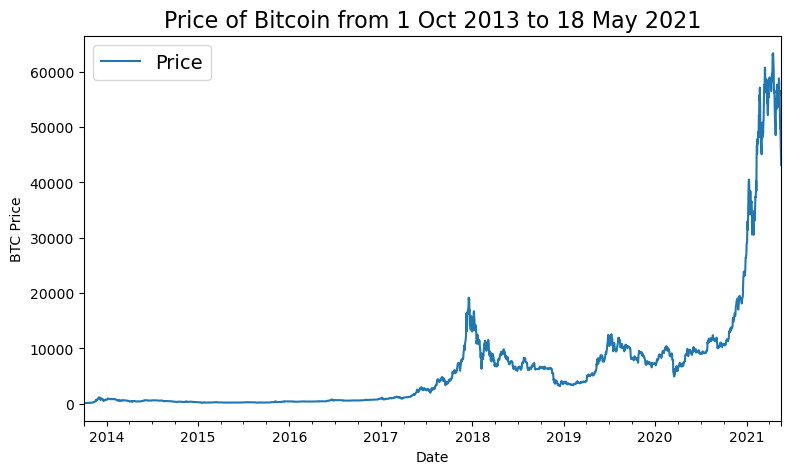

In [26]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

<b>Importando los datos usando el módulo CSV reader de python</b> (una alternativa a usar Pandas)

In [14]:
# Importing and formatting historical Bitcoin data with Python
timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

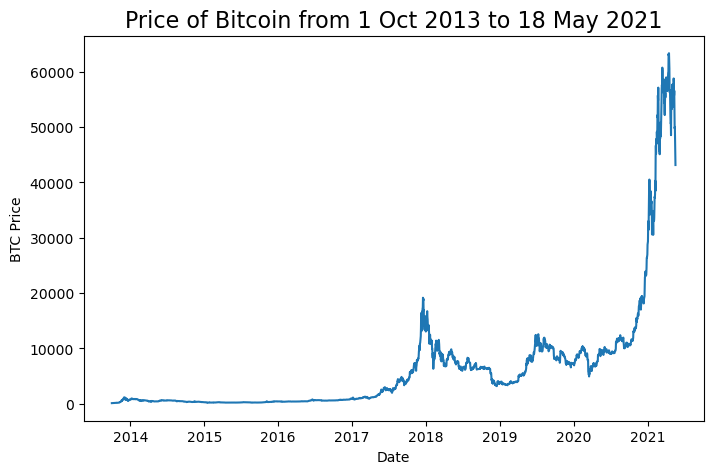

In [16]:
plt.figure(figsize=(8,5))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

In [22]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [23]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

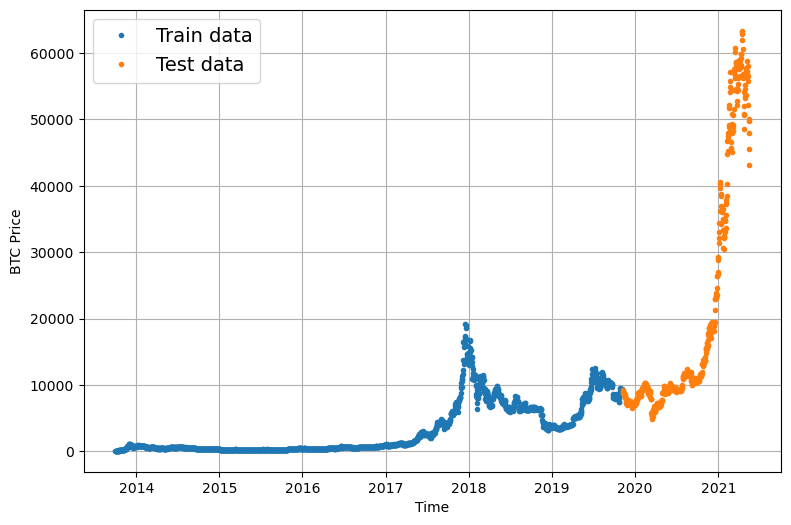

In [28]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelos a probar

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

<b> <font color='green'>Naive Forecast</font></b>

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [31]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

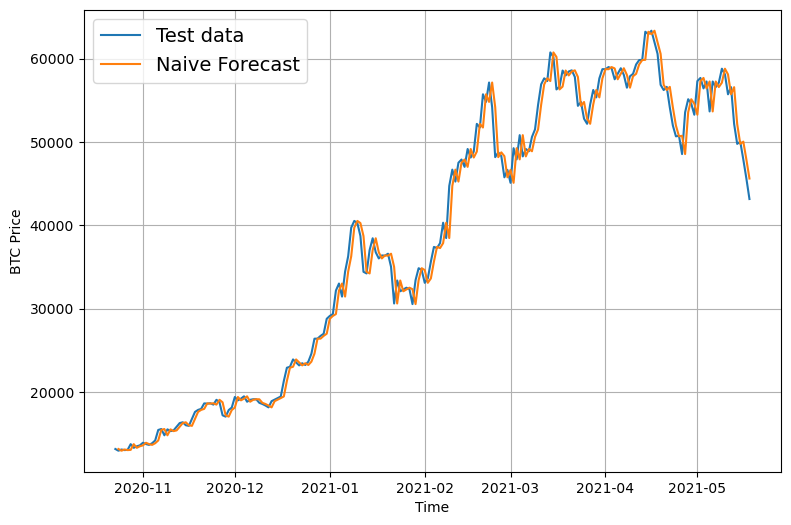

In [38]:
# Plot naive forecast
plt.figure(figsize=(9, 6))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

## Evaluando series temporales

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

<b> Implementando MASE </b>

In [50]:
# repaso reduce_mean

"""
tf.math.reduce_mean(
    input_tensor, axis=None, keepdims=False, name=None
)
"""

x = tf.constant( [ [1., 2.], [5.,3.] ])

print(x)

print(tf.math.reduce_mean(x)) # (1+2+5+3)/4  -> 2.75

print(tf.math.reduce_mean(x,axis=0)) # (1+5)/2 ; (2+3)/2

print(tf.math.reduce_mean(x,axis=1)) # (1+2)/2 ; (5+3)/2

print(tf.math.reduce_mean(x,axis=1,keepdims=True)) 

tf.Tensor(
[[1. 2.]
 [5. 3.]], shape=(2, 2), dtype=float32)
tf.Tensor(2.75, shape=(), dtype=float32)
tf.Tensor([3.  2.5], shape=(2,), dtype=float32)
tf.Tensor([1.5 4. ], shape=(2,), dtype=float32)
tf.Tensor(
[[1.5]
 [4. ]], shape=(2, 1), dtype=float32)


In [53]:
# ayuda para lo que sigue

y = np.array([1, 4, 7])


# yt - ty-1 : -> (7-4), (4-1)


print(y[1:]) # es desde la primera porque en la atrasada no tengo con qué restar al inicio
print(y[:-1])

y[1:] - y[:-1]



[4 7]
[1 4]


array([3, 3])

In [54]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [55]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

Función para computar las distintas métricas

In [56]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [57]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> antes usamos train/dev/test, ahora usaremos ventanas


Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [59]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [60]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [62]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [65]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite lsow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [123]:
# Ayuda de código


window_size = 3
horizon = 1


aux = np.array([10, 11, 12, 13, 14])


print(f"aux {aux}\n")


window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


print(f"window step: {window_step}\n")

window_indexes = window_step + np.expand_dims(np.arange(len(aux)-(window_size+horizon-1)), axis=0).T 


print(f"window indexes {window_indexes}")


aux[window_indexes]




#aux[[[0,1,2,3],[1,2,3,4]]]


aux [10 11 12 13 14]

window step: [[0 1 2 3]]

window indexes [[0 1 2 3]
 [1 2 3 4]]


array([[10, 11, 12, 13],
       [11, 12, 13, 14]])

In [78]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """



  #print(f"entrada: {x}\n")


  # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


  print(f"window setp: {window_step}\n")


  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
        # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")
        
    # np.arange(4) -> [0,1,2,3]
    """
    np.expand_dims(np.arange(4),axis=0).T + [[1]]
    array([[1],
           [2],
           [3],
           [4]])
    """
        
        
        
  #print(f"window_indexes: {window_indexes}\n")
        

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

                
  #print(f"windowed_array: {windowed_array}\n")
        

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [79]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

entrada: [  123.65499      125.455        108.58483    ... 47885.62525472
 45604.61575361 43144.47129086]

window setp: [[0 1 2 3 4 5 6 7]]

window_indexes: [[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]

windowed_array: [[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]



(2780, 2780)

In [124]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array 

In [159]:
"""
tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
"""


"""

La exploraré primero sólo con las entradas y leugo tmb. con los targets

"""




window_size = 3
horizon = 1
data = np.array([10, 11, 12, 13, 14])


aux = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=None,
    sequence_length=window_size,
    sequence_stride=horizon
)


for a in aux:
    print(a)




tf.Tensor(
[[10 11 12]
 [11 12 13]
 [12 13 14]], shape=(3, 3), dtype=int64)


In [160]:
aux = tf.keras.utils.timeseries_dataset_from_array(
    prices,
    targets=None,
    sequence_length=WINDOW_SIZE,
    sequence_stride=HORIZON
)

for a in aux:
    print(a)
    

tf.Tensor(
[[ 123.65499  125.455    108.58483  118.67466  121.33866  120.65533
   121.795  ]
 [ 125.455    108.58483  118.67466  121.33866  120.65533  121.795
   123.033  ]
 [ 108.58483  118.67466  121.33866  120.65533  121.795    123.033
   124.049  ]
 [ 118.67466  121.33866  120.65533  121.795    123.033    124.049
   125.96116]
 [ 121.33866  120.65533  121.795    123.033    124.049    125.96116
   125.27966]
 [ 120.65533  121.795    123.033    124.049    125.96116  125.27966
   125.9275 ]
 [ 121.795    123.033    124.049    125.96116  125.27966  125.9275
   126.38333]
 [ 123.033    124.049    125.96116  125.27966  125.9275   126.38333
   135.24199]
 [ 124.049    125.96116  125.27966  125.9275   126.38333  135.24199
   133.20333]
 [ 125.96116  125.27966  125.9275   126.38333  135.24199  133.20333
   142.76333]
 [ 125.27966  125.9275   126.38333  135.24199  133.20333  142.76333
   137.92333]
 [ 125.9275   126.38333  135.24199  133.20333  142.76333  137.92333
   142.95166]
 [ 126.38333

In [165]:
data = np.arange(1, 18)

# Definir la ventana de entrada (tamaño 3)
sequence_length = 3

# Crear el conjunto de datos usando timeseries_dataset_from_array
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=data[sequence_length:],  # Puedes ajustar esto según tus necesidades específicas
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=32  # Ajusta el tamaño del lote según tus necesidades
)

# Imprimir las muestras generadas
for batch in dataset:
    inputs, targets = batch
    print("Entradas:", inputs.numpy(), "Siguiente valor:", targets.numpy())


    
print(type(dataset))    


Entradas: [[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]] Siguiente valor: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


## Turning windows into training and test sets